
# 变分量子奇异值分解

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

在本教程中，我们一起学习下经典奇异值分解（singular value decomposition, SVD）的概念以及我们自主研发的量子神经网络版本的量子奇异值分解（variational quantum SVD, VQSVD）[1] 是如何运作的。主体部分包括两个具体案例：
- 分解随机生成的 $8\times8$ 复数矩阵；
- 应用在图像压缩上的效果。

## 背景

奇异值分解有非常多的应用，包括主成分分析（principal component analysis, PCA）、求解线性方程组和推荐系统。其主要任务是给定一个复数矩阵 $M \in \mathbb{C}^{m \times n}$, 找到如下的分解形式：$M = UDV^\dagger$。其中 $U_{m\times m}$ 和 $V^\dagger_{n\times n}$ 是酉矩阵（Unitary matrix）, 满足性质 $UU^\dagger = VV^\dagger = I$。 

- 矩阵 $U$ 的列向量 $|u_j\rangle$ 被称为左奇异向量（left singular vectors）, $\{|u_j\rangle\}_{j=1}^{m}$ 组成一组正交向量基。这些列向量本质上是矩阵 $MM^\dagger$ 的本征向量。
- 类似的，矩阵 $V$ 的列向量 $\{|v_j\rangle\}_{j=1}^{n}$ 是 $M^\dagger M$ 的本征向量也组成一组正交向量基。
- 中间矩阵 $D_{m\times n}$ 的对角元素上存储着由大到小排列的奇异值 $d_j$。 

我们不妨先来看个简单的例子（为了方便讨论，我们假设以下出现的 $M$ 都是方阵）：

$$
M = 2*X\otimes Z + 6*Z\otimes X + 3*I\otimes I = 
\begin{bmatrix} 
3 &6 &2 &0 \\
6 &3 &0 &-2 \\
2 &0 &3 &-6 \\
0 &-2 &-6 &3 
\end{bmatrix}, \tag{1}
$$

那么该矩阵的奇异值分解可表示为:

$$
M = UDV^\dagger = 
\frac{1}{2}
\begin{bmatrix} 
-1 &-1 &1 &1 \\
-1 &-1 &-1 &-1 \\
-1 &1 &-1 &1 \\
1 &-1 &-1 &1 
\end{bmatrix}
\begin{bmatrix} 
11 &0 &0 &0 \\
0 &7 &0 &0 \\
0 &0 &5 &0 \\
0 &0 &0 &1 
\end{bmatrix}
\frac{1}{2}
\begin{bmatrix} 
-1 &-1 &-1 &-1 \\
-1 &-1 &1 &1 \\
-1 &1 &1 &-1 \\
1 &-1 &1 &-1 
\end{bmatrix}. \tag{2}
$$

我们通过下面几行代码引入必要的 library和 package。



In [ ]:
import numpy as np
from numpy import pi as PI
from matplotlib import pyplot as plt
from scipy.stats import unitary_group
from scipy.linalg import norm

import paddle
from paddle_quantum.ansatz import Circuit
from paddle_quantum.linalg import dagger

In [2]:
# 画出优化过程中的学习曲线
def loss_plot(loss):
    '''
    loss is a list, this function plots loss over iteration
    '''
    plt.plot(list(range(1, len(loss)+1)), loss)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('Loss Over Iteration')
    plt.show()

## 经典奇异值分解

那么在了解一些简单的数学背景之后， 我们来学习下如何用 Numpy 完成矩阵的奇异值分解。

In [3]:
# 生成矩阵 M
def M_generator():
    I = np.array([[1, 0], [0, 1]])
    Z = np.array([[1, 0], [0, -1]])
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    M = 2 *np.kron(X, Z) + 6 * np.kron(Z, X) + 3 * np.kron(I, I)
    return M.astype('complex64')

print('我们想要分解的矩阵 M 是：')
print(M_generator())

我们想要分解的矩阵 M 是：
[[ 3.+0.j  6.+0.j  2.+0.j  0.+0.j]
 [ 6.+0.j  3.+0.j  0.+0.j -2.+0.j]
 [ 2.+0.j  0.+0.j  3.+0.j -6.+0.j]
 [ 0.+0.j -2.+0.j -6.+0.j  3.+0.j]]


In [4]:
# 我们只需要以下一行代码就可以完成 SVD 
U, D, V_dagger = np.linalg.svd(M_generator(), full_matrices=True)

# 打印分解结果
print("矩阵的奇异值从大到小分别是:")
print(D)
print("分解出的酉矩阵 U 是:")
print(U)
print("分解出的酉矩阵 V_dagger 是:")
print(V_dagger)

矩阵的奇异值从大到小分别是:
[11.  7.  5.  1.]
分解出的酉矩阵 U 是:
[[-0.5+0.j -0.5+0.j  0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j -0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j -0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]]
分解出的酉矩阵 V_dagger 是:
[[-0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j  0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
 [-0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]]


In [5]:
# 再组装回去，能不能复原矩阵？
M_reconst = np.matmul(U, np.matmul(np.diag(D), V_dagger))
print(M_reconst)

[[ 3.+0.j  6.+0.j  2.+0.j  0.+0.j]
 [ 6.+0.j  3.+0.j  0.+0.j -2.+0.j]
 [ 2.+0.j  0.+0.j  3.+0.j -6.+0.j]
 [ 0.+0.j -2.+0.j -6.+0.j  3.+0.j]]


那当然是可以复原成原来的矩阵 $M$ 的！读者也可以自行修改矩阵，试试看不是方阵的情况。

---



## 量子奇异值分解

接下来我们来看看量子版本的奇异值分解是怎么一回事。简单的说，我们把矩阵分解这一问题巧妙的转换成了优化问题。通过以下四个步骤：

- 准备一组正交向量基 $\{|\psi_j\rangle\}$, 不妨直接取计算基 $\{ |000\rangle, |001\rangle,\cdots |111\rangle\}$ （这是3量子比特的情形）
- 准备两个参数化的量子神经网络 $U(\theta)$ 和 $V(\phi)$ 分别用来学习左/右奇异向量
- 利用量子神经网络估算奇异值 $m_j = \text{Re}\langle\psi_j|U(\theta)^{\dagger} M V(\phi)|\psi_j\rangle$
- 设计损失函数并且利用飞桨来优化

$$
L(\theta,\phi) = \sum_{j=1}^T q_j\times \text{Re} \langle\psi_j|U(\theta)^{\dagger} M V(\phi)|\psi_j\rangle, \tag{3}
$$

其中 $q_1>\cdots>q_T>0$ 是可以调节的权重（超参数）, $T$ 表示我们想要学习到的阶数（rank）或者可以解释为总共要学习得到的奇异值个数。



### 案例1：分解随机生成的 $8\times8$ 复数矩阵

接着我们来看一个具体的例子，这可以更好的解释整体流程。

In [6]:
# 先固定随机种子， 为了能够复现结果
np.random.seed(42)

# 设置量子比特数量，确定希尔伯特空间的维度
N = 3

# 制作随机矩阵生成器
def random_M_generator():
    M = np.random.randint(10, size = (2**N, 2**N)) + 1j*np.random.randint(10, size = (2**N, 2**N))
    M1 = np.random.randint(10, size = (2**N, 2**N)) 
    return M

M = random_M_generator()
M_err = np.copy(M)

# 打印结果
print('我们想要分解的矩阵 M 是：')
print(M)

U, D, V_dagger = np.linalg.svd(M, full_matrices=True)
print("矩阵的奇异值从大到小分别是:")
print(D)

我们想要分解的矩阵 M 是：
[[6.+1.j 3.+9.j 7.+3.j 4.+7.j 6.+6.j 9.+8.j 2.+7.j 6.+4.j]
 [7.+1.j 4.+4.j 3.+7.j 7.+9.j 7.+8.j 2.+8.j 5.+0.j 4.+8.j]
 [1.+6.j 7.+8.j 5.+7.j 1.+0.j 4.+7.j 0.+7.j 9.+2.j 5.+0.j]
 [8.+7.j 0.+2.j 9.+2.j 2.+0.j 6.+4.j 3.+9.j 8.+6.j 2.+9.j]
 [4.+8.j 2.+6.j 6.+8.j 4.+7.j 8.+1.j 6.+0.j 1.+6.j 3.+6.j]
 [8.+7.j 1.+4.j 9.+2.j 8.+7.j 9.+5.j 4.+2.j 1.+0.j 3.+2.j]
 [6.+4.j 7.+2.j 2.+0.j 0.+4.j 3.+9.j 1.+6.j 7.+6.j 3.+8.j]
 [1.+9.j 5.+9.j 5.+2.j 9.+6.j 3.+0.j 5.+3.j 1.+3.j 9.+4.j]]
矩阵的奇异值从大到小分别是:
[54.83484985 19.18141073 14.98866247 11.61419557 10.15927045  7.60223249
  5.81040539  3.30116001]


In [7]:
# 超参数设置
N = 3           # 量子比特数量
T = 8           # 设置想要学习的阶数
ITR = 100       # 迭代次数
LR = 0.02       # 学习速率
SEED = 14       # 随机数种子

# 设置等差的学习权重
weight = np.arange(3 * T, 0, -3).astype('complex128')
print('选取的等差权重为：')
print(weight)

选取的等差权重为：
[24.+0.j 21.+0.j 18.+0.j 15.+0.j 12.+0.j  9.+0.j  6.+0.j  3.+0.j]


我们搭建如下的量子神经网络结构：

In [8]:
# 设置电路参数
cir_depth = 20                           # 电路深度
block_len = 2                            # 每个模组的长度

In [9]:
# 定义量子神经网络
def U_theta() -> Circuit:

    # 用 UAnsatz 初始化网络
    cir = Circuit(N)
    
    # 搭建层级结构：
    for _ in range(cir_depth):
        cir.ry()
        cir.rz()
        cir.cnot()

    return cir

接着我们来完成算法的主体部分：



In [10]:
class NET(paddle.nn.Layer):
    def __init__(self, matrix: np.ndarray, weights: np.ndarray) -> None:
        super(NET, self).__init__()
        
        # 创建用来学习 U_dagger 的量子神经网络
        self.cir_U = U_theta()
        
        # 创建用来学习 V_dagger 的量子神经网络
        self.cir_V = U_theta()
        
        # 将 Numpy array 转换成 Paddle 支持的 Tensor
        self.M = paddle.to_tensor(matrix)
        self.weight = paddle.to_tensor(weights)

    # 定义损失函数和前向传播机制
    def forward(self):
        
        # 获取量子神经网络的酉矩阵表示
        U = self.cir_U.unitary_matrix()
        U_dagger = dagger(U)
        
        V = self.cir_V.unitary_matrix()
        V_dagger = dagger(V)
        
        # 初始化损失函数和奇异值存储器
        loss = 0 
        singular_values = np.zeros(T)
        
        # 定义损失函数
        for i in range(T):
            loss -= paddle.real(self.weight)[i] * paddle.real(U_dagger @ self.M @ V)[i][i]
            singular_values[i] = paddle.real(U_dagger @ self.M @ V)[i][i].numpy()
        
        # 函数返回两个矩阵 U 和 V_dagger 学习的奇异值以及损失函数    
        return U, V_dagger, loss, singular_values


iter: 0 loss: -262.8009
iter: 10 loss: -1886.9825
iter: 20 loss: -2182.6929
iter: 30 loss: -2280.7289
iter: 40 loss: -2315.2391
iter: 50 loss: -2333.0160
iter: 60 loss: -2342.7280
iter: 70 loss: -2348.7263
iter: 80 loss: -2353.2796
iter: 90 loss: -2356.9237


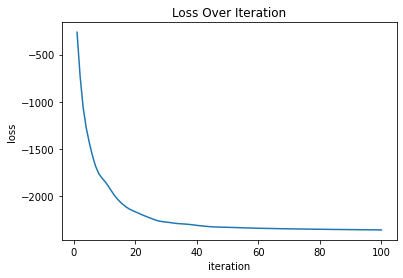

In [11]:
# 记录优化中间过程
loss_list, singular_value_list = [], []
U_learned, V_dagger_learned = [], []
    
# 确定网络的参数维度
net = NET(M, weight)

# 一般来说，我们利用 Adam 优化器来获得相对好的收敛
# 当然你可以改成 SGD 或者是 RMS prop.
opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

# 优化循环
for itr in range(ITR):

    #  前向传播计算损失函数
    U, V_dagger, loss, singular_values = net()

    # 反向传播极小化损失函数
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()

    # 记录优化中间结果
    loss_list.append(loss[0][0].numpy())
    singular_value_list.append(singular_values)
    
    if itr% 10 == 0:
        print('iter:', itr,'loss:','%.4f'% loss.numpy()[0])
        
# 绘制学习曲线
loss_plot(loss_list)

# 记录最后学出的两个酉矩阵    
U_learned = U.numpy()
V_dagger_learned = V_dagger.numpy()

接着我们来探究下量子版本的奇异值分解的精度问题。在上述部分，我们提到过可以用分解得到的更少的信息来表达原矩阵。具体来说，就是用前 $T$ 个奇异值和前 $T$ 列左右奇异向量重构一个矩阵：

$$
M_{re}^{(T)} = UDV^{\dagger}, \tag{4}
$$

并且对于一个本身秩 (rank) 为 $r$ 的矩阵 $M$, 误差随着使用奇异值的数量变多会越来越小。经典的奇异值算法可以保证：

$$
\lim_{T\rightarrow r} ||M - M_{re}^{(T)}||^2_2 = 0, \tag{5}
$$

其中矩阵间的距离测量由 Frobenius-norm 来计算,

$$
||M||_2 = \sqrt{\sum_{i,j} |M_{ij}|^2}. \tag{6}
$$

目前量子版本的奇异值分解还需要很长时间的优化，理论上只能保证上述误差不断减小。

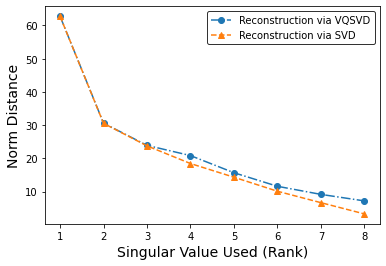

In [12]:
singular_value = singular_value_list[-1]
err_subfull, err_local, err_SVD = [], [], []
U, D, V_dagger = np.linalg.svd(M, full_matrices=True)

# 计算 Frobenius-norm 误差
for i in range(T):
    lowrank_mat = np.matrix(U[:, :i]) * np.diag(D[:i])* np.matrix(V_dagger[:i, :])
    recons_mat = np.matrix(U_learned[:, :i]) * np.diag(singular_value[:i])* np.matrix(V_dagger_learned[:i, :])
    err_local.append(norm(lowrank_mat - recons_mat)) 
    err_subfull.append(norm(M_err - recons_mat))
    err_SVD.append(norm(M_err- lowrank_mat))


# 画图 
fig, ax = plt.subplots()
ax.plot(list(range(1, T+1)), err_subfull, "o-.", 
        label = 'Reconstruction via VQSVD')
ax.plot(list(range(1, T+1)), err_SVD, "^--", 
        label='Reconstruction via SVD')
plt.xlabel('Singular Value Used (Rank)', fontsize = 14)
plt.ylabel('Norm Distance', fontsize = 14)
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('k')

---
### 案例2：图像压缩

为了做图像处理，我们先引入必要的 package。

In [13]:
# 图像处理包 PIL
from PIL import Image

# 打开提前准备好的图片
img = Image.open('./figures/MNIST_32.png')
imgmat = np.array(list(img.getdata(band=0)), float)
imgmat.shape = (img.size[1], img.size[0])
imgmat = np.matrix(imgmat)/255

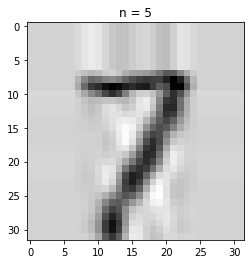

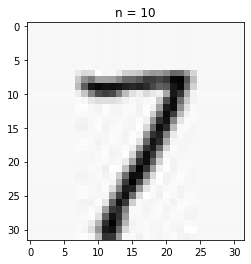

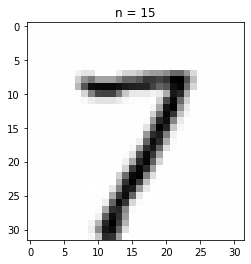

In [14]:
# 然后我们看看经典奇异值的分解效果
U, sigma, V = np.linalg.svd(imgmat)

for i in range(5, 16, 5):
    reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()

In [15]:
# 然后我们再来看看量子版本的分解效果：

# 超参数设置
N = 5           # 量子比特数量
T = 8           # 设置想要学习的阶数
ITR = 200       # 迭代次数
LR = 0.02        # 学习速率
SEED = 14       # 随机数种子

# 设置等差的学习权重
weight = np.arange(2 * T, 0, -2).astype('complex128')


def Mat_generator():
    imgmat = np.array(list(img.getdata(band=0)), float)
    imgmat.shape = (img.size[1], img.size[0])
    lenna = np.matrix(imgmat)
    return lenna.astype('complex128')

M_err = Mat_generator()
U, D, V_dagger = np.linalg.svd(Mat_generator(), full_matrices=True)

# 设置电路参数
cir_depth = 40                           # 电路深度
block_len = 1                            # 每个模组的长度

In [16]:
# 重新定义量子神经网络
def U_theta():

    # 用 Circuit 初始化网络
    cir = Circuit(N)
    
    # 搭建层级结构：
    for _ in range(cir_depth):
        cir.ry()
        cir.cnot()

    return cir

iter: 0 loss: -4291.2284
iter: 10 loss: -103444.3877
iter: 20 loss: -126821.2327
iter: 30 loss: -135986.5470
iter: 40 loss: -141457.8124
iter: 50 loss: -145045.8896
iter: 60 loss: -147249.5471
iter: 70 loss: -149020.3769
iter: 80 loss: -150570.5096
iter: 90 loss: -151898.1960
iter: 100 loss: -152989.3110
iter: 110 loss: -153869.6654
iter: 120 loss: -154547.8973
iter: 130 loss: -155069.0768
iter: 140 loss: -155459.7348
iter: 150 loss: -155744.3048
iter: 160 loss: -155957.9127
iter: 170 loss: -156124.0155
iter: 180 loss: -156257.4063
iter: 190 loss: -156367.2717


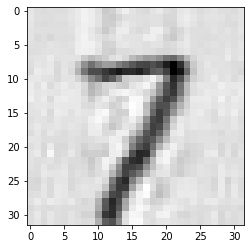

In [17]:
# 记录优化中间过程
loss_list, singular_value_list = [], []
U_learned, V_dagger_learned = [], []
    
net = NET(Mat_generator(), weight)

# 一般来说，我们利用 Adam 优化器来获得相对好的收敛
# 当然你可以改成 SGD 或者是 RMS prop.
opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

# 优化循环
for itr in range(ITR):

    #  前向传播计算损失函数
    U, V_dagger, loss, singular_values = net()

    # 反向传播极小化损失函数
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()

    # 记录优化中间结果
    loss_list.append(loss[0][0].numpy())
    singular_value_list.append(singular_values)
    
    if itr% 10 == 0:
        print('iter:', itr,'loss:','%.4f'% loss.numpy()[0])

# 记录最后学出的两个酉矩阵    
U_learned = U.numpy()
V_dagger_learned = V_dagger.numpy()

singular_value = singular_value_list[-1]
mat = np.matrix(U_learned.real[:, :T]) * np.diag(singular_value[:T])* np.matrix(V_dagger_learned.real[:T, :])

reconstimg = mat
plt.imshow(reconstimg, cmap='gray')

_______

## 参考文献

[1] Wang, X., Song, Z., & Wang, Y. Variational Quantum Singular Value Decomposition. [Quantum, 5, 483 (2021).](https://quantum-journal.org/papers/q-2021-06-29-483/)